# Import Libraries

In [1]:
import warnings

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import set_config

import mlflow
from mlflow import MlflowClient
from mlflow.models import infer_signature
import dagshub
import optuna
import shap
import dill

from typing import Optional, List, Dict

from ml.utils.utils import (
    get_data,
    remove_outliers
)

%matplotlib inline

# Dagshub Integration for MLflow Experiment Tracking

In [2]:
mlflow.is_tracking_uri_set()

False

In [3]:
dagshub.init(repo_owner='pramitde726', repo_name='Smartphone-Spec-Score-Analysis', mlflow=True)


Accessing as pramitde726

Initialized MLflow to track repo "pramitde726/Smartphone-Spec-Score-Analysis"

Repository pramitde726/Smartphone-Spec-Score-Analysis initialized!

In [4]:
mlflow.get_tracking_uri()

'https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow'

In [5]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

# Enable pandas output for the pipeline
set_config(transform_output="pandas")
# set_config(transform_output="default")

## Ignore warnings
warnings.filterwarnings("ignore")

## Read the Data

In [6]:
df = get_data("smartphone_cleaned_v2", "processed")
final_df = remove_outliers(df).drop(columns = ["model"])
final_df.head()

,price,rating,os,brand_name,has_5g,has_nfc,has_ir_blaster,num_cores,processor_speed,processor_brand,ram_capacity,internal_memory,battery_capacity,fast_charging,screen_size,resolution,refresh_rate,num_rear_cameras,num_front_cameras,primary_camera_rear,primary_camera_front,fast_charging_available,extended_memory_available,extended_upto
0,54999,89.0,android,oneplus,True,True,False,8.0,3.2,snapdragon,12.0,256.0,5000.0,100.0,6.70,1440 x 3216,120,3,1,50,16.0,1,0,0.0
1,19989,81.0,android,oneplus,True,False,False,8.0,2.2,snapdragon,6.0,128.0,5000.0,33.0,6.59,1080 x 2412,120,3,1,64,16.0,1,1,1024.0
2,16499,75.0,android,samsung,True,False,False,8.0,2.4,exynos,4.0,64.0,5000.0,15.0,6.60,1080 x 2408,90,3,1,50,13.0,1,1,1024.0
3,14999,81.0,android,motorola,True,False,False,8.0,2.2,snapdragon,6.0,128.0,5000.0,NaN,6.55,1080 x 2400,120,3,1,50,16.0,1,1,1024.0
4,24999,82.0,android,realme,True,False,False,8.0,2.6,dimensity,6.0,128.0,5000.0,67.0,6.70,1080 x 2412,120,3,1,108,16.0,1,0,0.0


## Train Test Split

In [7]:
cols_to_drop = ["os", "battery_capacity"]

In [8]:
X = final_df.dropna(subset=["rating"]).drop(columns=cols_to_drop).drop(columns='rating')
y = final_df['rating'].dropna()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (685, 21)
The shape of test data is (172, 21)


In [11]:
X_test.shape

(172, 21)

## Schema

In [12]:
standard_scale_cols = [
    'price', 'processor_speed', 'screen_size',
    'performance_score', 'camera_quality', 'storage_expandability'
]

minmax_scale_cols = ['connectivity_features']

nominal_cols = ['brand_name', 'processor_brand']

ordinal_cols = [
    "extended_upto",
    "has_5g",
    "has_nfc",
    "has_ir_blaster",
    "num_cores",
    "ram_capacity",
    "internal_memory",
    "fast_charging",
    "resolution",
    "refresh_rate",
    "num_rear_cameras",
    "primary_camera_rear",
    "primary_camera_front",
    "fast_charging_available",
    "extended_memory_available",
]

## Data Preprocessing 

### Imputation Pipeline

In [13]:
class DropNA(BaseEstimator, TransformerMixin):
    """
    A transformer that drops rows with missing values (NaN) from a Pandas DataFrame.

    :param subset: List of columns to consider when dropping rows with NaN values.
                   If None, all columns are considered.
    :type subset: Optional[List[str]], optional

    Attributes
    ----------
    subset : Optional[List[str]]
        List of columns to consider when dropping rows with NaN values.
    """
    def __init__(self, subset: Optional[List[str]] = None):
        self.subset = subset

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "DropNA":
        """
        Fit the transformer. This method does not actually perform any computation.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: DropNA
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Drop rows with missing values (NaN) from the input DataFrame.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with rows containing NaN values in the specified subset of columns removed.
        :rtype: pd.DataFrame
        """
        return X.dropna(subset=self.subset)

In [14]:


class ProcessorBrandImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'processor_brand' values in a DataFrame based on the 'brand_name'.

    This transformer learns the most frequent 'processor_brand' for each 'brand_name'
    during the `fit` method and uses this information to impute missing values
    during the `transform` method. Handles cases where a brand has no associated
    processor brand in the training data, or where a specific brand ('ikall' or 'tesla')
    should always have an 'Unknown' processor.

    Attributes
    ----------
    brand_processor_mode : Dict[str, str]
        A dictionary mapping 'brand_name' to the most frequent 'processor_brand'.
        Stores the mode for each brand name learned during the fit step.
    """
    def __init__(self):
        self.brand_processor_mode: Optional[Dict[str, str]] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ProcessorBrandImputer":
        """
        Learns the most frequent 'processor_brand' for each 'brand_name'.

        Calculates the mode of 'processor_brand' for each 'brand_name' present
        in the input DataFrame `X` and stores it in `self.brand_processor_mode`.

        :param X: The input DataFrame containing 'brand_name' and 'processor_brand' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ProcessorBrandImputer
        """
        self.brand_processor_mode = (
            X[X['processor_brand'].notnull()]
            .groupby('brand_name')['processor_brand']
            .agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
            .to_dict()
        )
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'processor_brand' values in the input DataFrame.

        Uses the learned `self.brand_processor_mode` to fill missing
        'processor_brand' values. If a 'brand_name' is not found in the
        learned mapping, 'Unknown' is used as the imputation value. Also handles
        special cases where 'ikall' and 'tesla' brands are always assigned
        the 'Unknown' processor.

        :param X: The input DataFrame containing 'brand_name' and 'processor_brand' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'processor_brand' values imputed.
        :rtype: pd.DataFrame
        """
        def impute_processor(row):
            if row['brand_name'] in ['ikall', 'tesla']:
                return 'Unknown'
            elif pd.isnull(row['processor_brand']):
                return self.brand_processor_mode.get(row['brand_name'], 'Unknown')
            return row['processor_brand']

        X['processor_brand'] = X.apply(impute_processor, axis=1)
        return X

In [15]:
class BatteryCapacityImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'battery_capacity' values with the median battery capacity
    of Apple devices.

    This transformer calculates the median 'battery_capacity' for devices where
    'brand_name' (case-insensitive) is 'apple' during the `fit` method and uses
    this median to fill missing 'battery_capacity' values during the `transform`
    method.

    Attributes
    ----------
    apple_median : Optional[float]
        The median battery capacity of Apple devices.
    """
    def __init__(self):
        self.apple_median: Optional[float] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "BatteryCapacityImputer":
        """
        Calculates the median battery capacity for Apple devices.

        :param X: The input DataFrame containing 'brand_name' and 'battery_capacity' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: BatteryCapacityImputer
        """
        self.apple_median = X.loc[X['brand_name'].str.lower() == 'apple', 'battery_capacity'].median()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'battery_capacity' values with the calculated median.

        :param X: The input DataFrame containing 'battery_capacity' column.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'battery_capacity' values imputed.
        :rtype: pd.DataFrame
        """
        X['battery_capacity'] = X['battery_capacity'].fillna(self.apple_median)
        return X


class ExtendedUptoImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'extended_upto' values with the median 'extended_upto' value
    for devices where 'extended_memory_available' is 1.

    Attributes
    ----------
    extended_memory_median : Optional[float]
        The median 'extended_upto' value for devices with extended memory available.
    """
    def __init__(self):
        self.extended_memory_median: Optional[float] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ExtendedUptoImputer":
        """
        Calculates the median 'extended_upto' value for devices with extended memory.

        :param X: The input DataFrame containing 'extended_memory_available' and 'extended_upto' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ExtendedUptoImputer
        """
        self.extended_memory_median = X.loc[X['extended_memory_available'] == 1, 'extended_upto'].median()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'extended_upto' values.

        :param X: The input DataFrame containing 'extended_upto' column.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'extended_upto' values imputed.
        :rtype: pd.DataFrame
        """
        X['extended_upto'] = X.apply(
            lambda row: row['extended_upto'] if pd.notnull(row['extended_upto'])
            else self.extended_memory_median,
            axis=1
        )
        return X


class FastChargingImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values to 0 when 'fast_charging_available' is 0.
    """
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "FastChargingImputer":
        """
        Fit the transformer. This method does not actually perform any computation.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: FastChargingImputer
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes 'fast_charging' values.

        Sets 'fast_charging' to 0 if 'fast_charging_available' is 0 and 'fast_charging' is NaN.

        :param X: The input DataFrame containing 'fast_charging' and 'fast_charging_available' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values.
        :rtype: pd.DataFrame
        """
        X['fast_charging'] = X.apply(
            lambda row: 0 if row['fast_charging_available'] == 0 and pd.isnull(row['fast_charging'])
            else row['fast_charging'],
            axis=1
        )
        return X

In [16]:
class ConsistentBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('lg', 'oneplus', 'xiaomi', 'vivo') during the `fit` method.
    It then uses these medians to impute missing 'fast_charging' values for the
    respective brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        consistent brand.
    """
    import pandas as pd 
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}  # Store median fast_charging for each brand

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ConsistentBrandsImputer":
        """
        Calculates the median 'fast_charging' for consistent brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ConsistentBrandsImputer
        """
        consistent_brands = ['lg', 'oneplus', 'xiaomi', 'vivo']
        for brand in consistent_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for consistent brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for consistent brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [17]:
class HigherMissingBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('samsung', 'apple') during the `fit` method. It then uses
    these medians to impute missing 'fast_charging' values for the respective
    brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        specified brand.
    """
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "HigherMissingBrandsImputer":
        """
        Calculates the median 'fast_charging' for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: HigherMissingBrandsImputer
        """
        higher_missing_brands = ['samsung', 'apple']
        for brand in higher_missing_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for specified brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [18]:
class LowerMissingBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('sony', 'xiaomi', 'oppo', 'motorola', 'google') during the
    `fit` method. It then uses these medians to impute missing 'fast_charging'
    values for the respective brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        specified brand.
    """
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "LowerMissingBrandsImputer":  
        """
        Calculates the median 'fast_charging' for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: LowerMissingBrandsImputer 
        """
        lower_missing_brands = ['sony', 'xiaomi', 'oppo', 'motorola', 'google']
        for brand in lower_missing_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for specified brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [19]:
class SingleRecordBrandsRemover(BaseEstimator, TransformerMixin):
    """
    Removes records associated with specific brands from a DataFrame.

    This transformer removes rows where the 'brand_name' (case-insensitive) is
    present in a predefined or user-provided list of brands.

    Attributes
    ----------
    brands_to_remove : List[str], default=['blu', 'leitz', 'sharp']
        A list of brand names to remove from the DataFrame.
    """
    def __init__(self, brands_to_remove: Optional[List[str]] = None):
        self.brands_to_remove = brands_to_remove or ['blu', 'leitz', 'sharp']  # Default brands

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "SingleRecordBrandsRemover":
        """
        Fit the transformer. This method does not actually perform any computation.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: SingleRecordBrandsRemover
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Removes records associated with the specified brands.

        :param X: The input DataFrame containing the 'brand_name' column.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with records associated with the specified brands removed.
        :rtype: pd.DataFrame
        """
        return X[~X['brand_name'].str.lower().isin(self.brands_to_remove)]

In [20]:
class OSByBrandImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'os' values based on the mode 'os' for each 'brand_name'.

    This transformer calculates the mode of the 'os' column for each
    'brand_name' during the `fit` method and uses these modes to impute
    missing 'os' values during the `transform` method.

    Attributes
    ----------
    os_mode : Dict[str, Optional[str]]
        A dictionary mapping each 'brand_name' to its most frequent 'os' value.
        Can be None if fit has not been called.
    """
    def __init__(self):
        self.os_mode: Optional[Dict[str, Optional[str]]] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "OSByBrandImputer":  # String literal
        """
        Calculates the mode 'os' for each 'brand_name'.

        :param X: The input DataFrame containing 'brand_name' and 'os' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: OSByBrandImputer
        """
        self.os_mode = X.groupby('brand_name')['os'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'os' values based on the calculated modes.

        :param X: The input DataFrame containing 'brand_name' and 'os' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'os' values.
        :rtype: pd.DataFrame
        """
        X['os'] = X.apply(
            lambda row: self.os_mode.get(row['brand_name']) if pd.isnull(row['os']) else row['os'], axis=1
        )
        return X

In [21]:
# Handle missing values pipeline
missing_handler = Pipeline([
    ('camera_dropna', DropNA(subset=["primary_camera_front"])),
    ('processor_brand', ProcessorBrandImputer()),
    ('num_cores_dropna', DropNA(subset=["num_cores"])),
    ('processor_speed_dropna', DropNA(subset=["processor_speed"])),
    ('extended_upto', ExtendedUptoImputer()),
    ('fast_charging',  FastChargingImputer()),
    ('consistent_brands', ConsistentBrandsImputer()),
    ('higher_missing_brands', HigherMissingBrandsImputer()),
    ('lower_missing_brands', LowerMissingBrandsImputer()),
    ('single_record_brands', SingleRecordBrandsRemover()),
])
    

### Feature Construction 

In [22]:
def compute_performance_score(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a performance score based on processor speed, number of cores, and RAM capacity.

    :param X: The input DataFrame containing 'processor_speed', 'num_cores', and 'ram_capacity' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'performance_score' column.
    :rtype: pd.DataFrame
    """
    import pandas as pd 
    X = X.copy()
    X["performance_score"] = (
        X["processor_speed"] * X["num_cores"].astype(float) * X["ram_capacity"].astype(float)
    )
    return X

def compute_battery_efficiency(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes battery efficiency based on battery capacity and screen size.

    :param X: The input DataFrame containing 'battery_capacity' and 'screen_size' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'battery_efficiency' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["battery_efficiency"] = X["battery_capacity"] / X["screen_size"]
    return X

def compute_camera_quality(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes camera quality based on rear and front camera megapixels.

    :param X: The input DataFrame containing 'primary_camera_rear' and 'primary_camera_front' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'camera_quality' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["camera_quality"] = X["primary_camera_rear"].astype(float) + X["primary_camera_front"].astype(float)
    return X

def compute_connectivity_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a connectivity features score based on 5g, NFC, and IR blaster availability.

    :param X: The input DataFrame containing 'has_5g', 'has_nfc', and 'has_ir_blaster' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'connectivity_features' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["connectivity_features"] = X[["has_5g", "has_nfc", "has_ir_blaster"]].sum(axis=1)
    return X

def compute_storage_expandability(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes storage expandability based on maximum expandable memory and availability.

    :param X: The input DataFrame containing 'extended_upto' and 'extended_memory_available' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'storage_expandability' column.
    :rtype: pd.DataFrame
    """
    import pandas as pd 
    X = X.copy()
    X["storage_expandability"] = X["extended_upto"].astype(float) * X["extended_memory_available"].astype(int)
    return X

In [23]:
# feature construction pipeline

feature_constructor = Pipeline([
    ("performance_score", FunctionTransformer(compute_performance_score)),
    ("camera_quality", FunctionTransformer(compute_camera_quality)),
    ("connectivity_features", FunctionTransformer(compute_connectivity_features)),
    ("storage_expandability", FunctionTransformer(compute_storage_expandability)),
])

### High Cardinality 

In [24]:
def encode_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes categorical and numerical features into discrete categories.

    This function performs binning and grouping operations on several features
    to convert them into categorical representations. It handles 'resolution',
    'brand_name', 'ram_capacity', 'processor_brand', 'fast_charging',
    'primary_camera_rear', 'primary_camera_front', and 'extended_upto'.

    :param X: The input DataFrame.
    :type X: pd.DataFrame
    :return: The DataFrame with encoded features.
    :rtype: pd.DataFrame
    """
    X = X.copy()

    # resolution
    X['resolution'] = np.select(
        [
            X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 1080,
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 1080) &
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 1440),
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 1440) &
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 2160),
            X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 2160,
        ],
        ["HD Ready", "Full HD", "Quad HD", "Ultra HD"],
        default="Unknown"
    )

    # brand_name
    X['brand_name'] = X['brand_name'].mask(X['brand_name'].map(X['brand_name'].value_counts()) < 10, "other")

    # ram_capacity
    X['ram_capacity'] = np.select(
        [
            X["ram_capacity"].astype(float) <= 4,
            X["ram_capacity"].astype(float) <= 8
        ],
        ["Low", "Standard"],
        default="High"
    )

    # processor_brand
    X['processor_brand'] = X['processor_brand'].mask(X['processor_brand'].map(X['processor_brand'].value_counts()) < 5, "other")

    # fast_charging
    X['fast_charging'] = np.select(
        [
            X["fast_charging"] == 0.0,
            (X["fast_charging"] > 0.0) & (X["fast_charging"] <= 18),
            (X["fast_charging"] > 18) & (X["fast_charging"] <= 33),
            (X["fast_charging"] > 33) & (X["fast_charging"] <= 65),
            (X["fast_charging"] > 65) & (X["fast_charging"] <= 120)
        ],
        ["no", "basic", "moderate", "fast", "ultra fast"],
        default="extreme fast"
    )

    # primary_camera_rear
    X['primary_camera_rear'] = np.select(
        [
            X["primary_camera_rear"].astype(float) <= 8,
            (X["primary_camera_rear"].astype(float) > 8) & (X["primary_camera_rear"].astype(float) <= 16),
            (X["primary_camera_rear"].astype(float) > 16) & (X["primary_camera_rear"].astype(float) <= 48),
            (X["primary_camera_rear"].astype(float) > 48) & (X["primary_camera_rear"].astype(float) <= 64),
            (X["primary_camera_rear"].astype(float) > 64) & (X["primary_camera_rear"].astype(float) <= 108)
        ],
        ["basic", "standard", "good", "high-Resolution", "ultra-high"],
        default="extreme"
    )

    # primary_camera_front
    X['primary_camera_front'] = np.select(
        [
            X["primary_camera_front"].astype(float) <= 8,
            (X["primary_camera_front"].astype(float) > 8) & (X["primary_camera_front"].astype(float) <= 16),
            (X["primary_camera_front"].astype(float) > 16) & (X["primary_camera_front"].astype(float) <= 32),
            (X["primary_camera_front"].astype(float) > 32) & (X["primary_camera_front"].astype(float) <= 48)
        ],
        ["basic", "standard", "good", "high-resolution"],
        default="ultra high"
    )

    # extended_upto
    X['extended_upto'] = np.select(
        [
            X["extended_upto"] == 0.0,
            X["extended_upto"].isin([64.0, 128.0, 256.0]),
            X["extended_upto"] == 512.0,
            X["extended_upto"] == 1024.0,
            X["extended_upto"] == 2048.0
        ],
        ["no expansion", "small", "medium", "large", "very large"],
        default="unknown"
    )

    return X

### Feature Encoding

In [25]:
# generate order for ordinal encoding

ordinal_categories = [
    ["no expansion", "small", "medium", "large", "very large", "unknown"],  # extended_upto
    [False, True],  # has_5g
    [False, True],  # has_nfc
    [False, True],  # has_ir_blaster
    [4.0, 6.0, 8.0],  # num_cores
    ["Low", "Standard", "High"],  # ram_capacity
    [8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0],  # internal_memory
    ["no", "basic", "moderate", "fast", "ultra fast", "extreme fast"],  # fast_charging
    ["HD Ready", "Full HD", "Quad HD", "Ultra HD"],  # resolution
    [60, 90, 120, 144, 165],  # refresh_rate
    [1, 2, 3, 4],  # num_rear_cameras
    ["basic", "standard", "good", "high-Resolution", "ultra-high", "extreme"],  # primary_camera_rear
    ["basic", "standard", "good", "high-resolution", "ultra high"],  # primary_camera_front
    [0, 1],  # fast_charging_available
    [0, 1]   # extended_memory_available
]


In [26]:
feature_encoder = ColumnTransformer([
    ('standard_scaling', StandardScaler(), standard_scale_cols),
    ('minmax_scaling', MinMaxScaler(), minmax_scale_cols),
    ('nominal_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols),
    ('ordinal_encoding', OrdinalEncoder(categories=ordinal_categories, 
                                        handle_unknown="use_encoded_value", 
                                        unknown_value=-1), ordinal_cols)
])

### Preprocessor Pipeline

In [27]:
preprocessor = Pipeline([
    ('handle_missing', missing_handler),
    ('feature_construction', feature_constructor),
    ('high_cardinality', FunctionTransformer(encode_features)),
    ('feature_encoding', feature_encoder)  
])

In [28]:
preprocessor

Pipeline(steps=[('handle_missing',
                 Pipeline(steps=[('camera_dropna',
                                  DropNA(subset=['primary_camera_front'])),
                                 ('processor_brand', ProcessorBrandImputer()),
                                 ('num_cores_dropna',
                                  DropNA(subset=['num_cores'])),
                                 ('processor_speed_dropna',
                                  DropNA(subset=['processor_speed'])),
                                 ('extended_upto', ExtendedUptoImputer()),
                                 ('fast_charging', FastChargingImputer()),
                                 ('cons...
                                                                              'high-resolution',
                                                                              'ultra '
                                                                              'high'],
                                                                             [0,
                                                                              1],
                                                                             [0,
                                                                              1]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['extended_upto', 'has_5g',
                                                   'has_nfc', 'has_ir_blaster',
                                                   'num_cores', 'ram_capacity',
                                                   'internal_memory',
                                                   'fast_charging',
                                                   'resolution', 'refresh_rate',
                                                   'num_rear_cameras',
                                                   'primary_camera_rear',
                                                   'primary_camera_front',
                                                   'fast_charging_available',
                                                   'extended_memory_available'])]))])

In [29]:
preprocessor.get_params(deep=True)

{'memory': None,
 'steps': [('handle_missing',
   Pipeline(steps=[('camera_dropna', DropNA(subset=['primary_camera_front'])),
                   ('processor_brand', ProcessorBrandImputer()),
                   ('num_cores_dropna', DropNA(subset=['num_cores'])),
                   ('processor_speed_dropna', DropNA(subset=['processor_speed'])),
                   ('extended_upto', ExtendedUptoImputer()),
                   ('fast_charging', FastChargingImputer()),
                   ('consistent_brands', ConsistentBrandsImputer()),
                   ('higher_missing_brands', HigherMissingBrandsImputer()),
                   ('lower_missing_brands', LowerMissingBrandsImputer()),
                   ('single_record_brands',
                    SingleRecordBrandsRemover(brands_to_remove=['blu', 'leitz',
                                                                'sharp']))])),
  ('feature_construction',
   Pipeline(steps=[('performance_score',
                    FunctionTransformer(fun

In [30]:
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [31]:
y_train_trans = y_train.loc[X_train_trans.index]
y_test_trans = y_test.loc[X_test_trans.index]

### Export preprocessor object

In [29]:
processor_path = "../../artifacts/preprocessor.pkl"

In [30]:
with open(processor_path, "wb") as f: 
    dill.dump(preprocessor, f)

In [31]:
with open(processor_path, "rb") as f: 
    loaded_preprocessor = dill.load(f)

In [32]:
loaded_preprocessor.transform(X_test)

,standard_scaling__price,standard_scaling__processor_speed,standard_scaling__screen_size,standard_scaling__performance_score,standard_scaling__camera_quality,standard_scaling__storage_expandability,minmax_scaling__connectivity_features,nominal_encoding__brand_name_apple,nominal_encoding__brand_name_infinix,nominal_encoding__brand_name_iqoo,nominal_encoding__brand_name_motorola,nominal_encoding__brand_name_oneplus,nominal_encoding__brand_name_oppo,nominal_encoding__brand_name_other,nominal_encoding__brand_name_poco,nominal_encoding__brand_name_realme,nominal_encoding__brand_name_samsung,nominal_encoding__brand_name_tecno,nominal_encoding__brand_name_vivo,nominal_encoding__brand_name_xiaomi,nominal_encoding__processor_brand_bionic,nominal_encoding__processor_brand_dimensity,nominal_encoding__processor_brand_exynos,nominal_encoding__processor_brand_helio,nominal_encoding__processor_brand_other,nominal_encoding__processor_brand_snapdragon,nominal_encoding__processor_brand_tiger,nominal_encoding__processor_brand_unisoc,ordinal_encoding__extended_upto,ordinal_encoding__has_5g,ordinal_encoding__has_nfc,ordinal_encoding__has_ir_blaster,ordinal_encoding__num_cores,ordinal_encoding__ram_capacity,ordinal_encoding__internal_memory,ordinal_encoding__fast_charging,ordinal_encoding__resolution,ordinal_encoding__refresh_rate,ordinal_encoding__num_rear_cameras,ordinal_encoding__primary_camera_rear,ordinal_encoding__primary_camera_front,ordinal_encoding__fast_charging_available,ordinal_encoding__extended_memory_available
808,-0.704344,-1.391367,0.262548,-1.025108,-0.236947,1.068215,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,3.0,1.0,1.0,0.0,2.0,3.0,0.0,1.0,1.0
682,6.281217,1.939490,0.760351,-0.151193,-1.242373,-1.142703,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0
132,-0.889175,-1.438951,-0.235256,-1.034804,-0.296089,1.068215,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0
232,-0.671727,-0.011440,0.760351,0.419701,-0.325661,1.068215,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,4.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,1.0
430,0.578108,1.891907,0.760351,1.195436,0.886765,-1.142703,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,4.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,3.894674,1.939490,-2.226471,-0.151193,-1.242373,-1.142703,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,6.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
260,-0.481460,-0.011440,1.755959,0.419701,-0.000376,-0.037244,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,4.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0
373,1.013492,0.702315,-0.733060,0.710602,-1.183230,-0.037244,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0
240,-0.564634,-0.249359,0.063426,-0.792387,-1.331087,1.068215,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


### Export training and test data

In [39]:
train_path = "../../artifacts/train.csv"
test_x_path = "../../artifacts/test_x.csv"
test_y_path = "../../artifacts/test_y.csv"

In [40]:
# X_train.to_csv(train_path, index=False)
X_test.to_csv(test_x_path, index=False)
y_test.to_csv(test_y_path, index=False)

### Tuning Random Forest

In [36]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - Tuning Best Model")


<Experiment: artifact_location='mlflow-artifacts:/fea608b5f6dc4bc7a2b2c93635119bd8', creation_time=1739519178044, experiment_id='5', last_update_time=1739519178044, lifecycle_stage='active', name='Exp 4 - Tuning Best Model', tags={}>

In [ ]:
from typing import Any


def objective(trial: optuna.trial.Trial) -> float:
    """
    Objective function for Optuna optimization of a RandomForestRegressor model.

    This function defines the search space for hyperparameters, trains and evaluates
    the model using cross-validation, logs metrics and parameters to MLflow, and
    returns the mean cross-validation score.

    :param trial: The Optuna trial object.
    :type trial: optuna.trial.Trial
    :return: The mean cross-validation R-squared score.
    :rtype: float
    """
    with mlflow.start_run(nested=True):
        params: Dict[str, Any] = {
            "n_estimators": 500,
            "max_depth": trial.suggest_int("max_depth", 10, 30, step=5),
            "min_samples_split": trial.suggest_int("min_samples_split", 15, 25),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 20),
            "bootstrap": True,
            "ccp_alpha": trial.suggest_loguniform("ccp_alpha", 5e-4, 5e-2),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
            "random_state": 42
        }

        # Train & evaluate model with these parameters
        model: RandomForestRegressor = RandomForestRegressor(**params)
        scores: np.ndarray = cross_val_score(model, X_train_trans, y_train_trans, cv=5, scoring="r2", n_jobs=-1)

        # Log model params
        mlflow.log_params(model.get_params())

        # log model_name
        mlflow.log_param("model", "Tuned Random Forest")

        # Log cross-validation score
        mlflow.log_metric("cross_val", scores.mean())

        return scores.mean()

In [103]:
# Create Optuna study
study = optuna.create_study(direction="maximize", study_name="rf_tuning")

with mlflow.start_run(run_name="Best Model") as parent:
    # Optimize hyperparameters
    study.optimize(objective, n_trials=30, n_jobs=-1)

    # Log the best hyperparameters
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_score", study.best_value)

    # Create the best model with optimized parameters
    best_model = RandomForestRegressor(**study.best_params, random_state=42)
    best_model.fit(X_train_trans, y_train_trans) 

    # Log the best model
    signature = infer_signature(X_train_trans, best_model.predict(X_train_trans))
    mlflow.sklearn.log_model(
        sk_model=best_model, 
        artifact_path="best_model", 
        signature=signature, 
        input_example=X_train_trans[:5]
    ) 

    # Register the model
    result = mlflow.register_model(
        f"runs:/{parent.info.run_id}/best_model", 
        "smartphones_prod",  
    )
    print(f"Registered model version: {result.version}")

[I 2025-02-15 20:11:02,279] A new study created in memory with name: rf_tuning


🏃 View run orderly-grub-506 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/21591d45875f4b74b901820e60070855
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:11:07,324] Trial 5 finished with value: 0.926345869389659 and parameters: {'max_depth': 10, 'min_samples_split': 25, 'min_samples_leaf': 16, 'ccp_alpha': 0.001375624998505752, 'max_features': 0.5}. Best is trial 5 with value: 0.926345869389659.


🏃 View run handsome-shrimp-180 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/dcafa18ff4d1490dae92c0fbc6472df9
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:11:22,692] Trial 6 finished with value: 0.9019288168525934 and parameters: {'max_depth': 15, 'min_samples_split': 25, 'min_samples_leaf': 15, 'ccp_alpha': 0.0012633403453324336, 'max_features': 'log2'}. Best is trial 5 with value: 0.926345869389659.


🏃 View run kindly-wren-557 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/1a936a58ac464d3fbdd5d0471a295d09
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:11:32,705] Trial 4 finished with value: 0.9261340336235186 and parameters: {'max_depth': 10, 'min_samples_split': 21, 'min_samples_leaf': 16, 'ccp_alpha': 0.03732633617445587, 'max_features': 0.5}. Best is trial 5 with value: 0.926345869389659.


🏃 View run likeable-croc-580 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/ef0d6a8355ca4766b436e9d5cf639593
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run ambitious-pig-116 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/c0ef69ae927b4a0b8691aa1f748f2bba
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run classy-stork-347 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/f87f9a136e274fd6b6efde24d8a9eafc
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run nervous-bass-797 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/64282b2e80af4e42b0aa81cb2e9c4894
🧪 View experiment at: https://dagshub.com/pramitde

[I 2025-02-15 20:11:43,717] Trial 2 finished with value: 0.9357105593468802 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005691743510242201, 'max_features': 0.5}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run righteous-gnat-567 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/81ab03f9ca534e59aa22cabb660d5eb4
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:11:45,754] Trial 7 finished with value: 0.9225595932357231 and parameters: {'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 16, 'ccp_alpha': 0.0485981972727529, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:11:46,702] Trial 3 finished with value: 0.8935966852363517 and parameters: {'max_depth': 20, 'min_samples_split': 24, 'min_samples_leaf': 18, 'ccp_alpha': 0.007897621758013241, 'max_features': 'log2'}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:11:48,688] Trial 0 finished with value: 0.9279098822699933 and parameters: {'max_depth': 25, 'min_samples_split': 22, 'min_samples_leaf': 13, 'ccp_alpha': 0.0021390162034333176, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:11:50,713] Trial 1 finished with value: 0.9263398045803107 and parameters: {'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 16, 'ccp_alpha': 0.006299680694930497, 'max_feature

🏃 View run abundant-foal-289 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/aaeb4c8936a948528e083a184aa6ef60
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:12:10,709] Trial 9 finished with value: 0.9177569546743216 and parameters: {'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 19, 'ccp_alpha': 0.0028487319795865397, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run unequaled-doe-965 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/a57cd9e810b94593b5edb867a298fb8c
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:12:20,704] Trial 10 finished with value: 0.9018934080020822 and parameters: {'max_depth': 25, 'min_samples_split': 21, 'min_samples_leaf': 15, 'ccp_alpha': 0.019183027934363953, 'max_features': 'log2'}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run painted-eel-732 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/3b5ec5a9e890422fb384c9049f806030
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run bright-hare-109 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/5817df568b454ae68d4aa7e5eb3d6861
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run thundering-goose-515 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/af9b80a54e1d45068086762e497155f6
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run marvelous-bug-487 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/d3e004ef4a0742c6bbf351b2f78dd1c4
🧪 View experiment at: https://dagshub.com/pramitd

[I 2025-02-15 20:12:31,711] Trial 11 finished with value: 0.9310213050259021 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 13, 'ccp_alpha': 0.001215063963582259, 'max_features': 0.5}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run welcoming-flea-890 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/d61b7560bdd5409993c79f89d0bb1cab
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:12:33,714] Trial 12 finished with value: 0.9214439601292937 and parameters: {'max_depth': 10, 'min_samples_split': 24, 'min_samples_leaf': 19, 'ccp_alpha': 0.0012897906170824941, 'max_features': 0.5}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:12:34,707] Trial 13 finished with value: 0.9029690350382952 and parameters: {'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 18, 'ccp_alpha': 0.004615746850754264, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:12:36,694] Trial 14 finished with value: 0.9147475574146406 and parameters: {'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 13, 'ccp_alpha': 0.0009215848540444271, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:12:38,708] Trial 15 finished with value: 0.9321693027974465 and parameters: {'max_depth': 15, 'min_samples_split': 22, 'min_samples_leaf': 10, 'ccp_alpha': 0.04838708997542307, 'ma

🏃 View run loud-crow-958 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/bf824b39981a44fa9d77b234fd828961
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:12:58,710] Trial 17 finished with value: 0.9224524933752558 and parameters: {'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005918932184554869, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run able-skink-907 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/f20a0322ca0b4cc6ae984b3d80e2e977
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:13:08,710] Trial 18 finished with value: 0.922452590683293 and parameters: {'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005254028495615224, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run welcoming-snail-124 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/5158752df4f142408a5809c88048f0e0
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run receptive-eel-360 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/012a6fa3fca64e1bbd780d576a8657f0
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run clumsy-cub-924 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/5980778b7ef744f8badd4f37e6fb27ba
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run unleashed-cow-830 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/31da3b08c7e542d0af5746507c9f7130
🧪 View experiment at: https://dagshub.com/pramitd

[I 2025-02-15 20:13:19,981] Trial 19 finished with value: 0.9328386546764769 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 10, 'ccp_alpha': 0.02192031863104913, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run brawny-wasp-193 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/c739b382d6f1451cb091480d03b47b99
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:13:21,693] Trial 20 finished with value: 0.9330449284176134 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005361127465449979, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:13:22,703] Trial 21 finished with value: 0.9330445025030161 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 10, 'ccp_alpha': 0.000643912540530261, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:13:24,712] Trial 22 finished with value: 0.9330449249073005 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005461941900159862, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:13:26,696] Trial 23 finished with value: 0.9330449233203926 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 10, 'ccp_alpha': 0.0005047235314150934, 'max_fe

🏃 View run invincible-whale-614 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/cbf8709292114634a8149b0e34997700
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:13:40,701] Trial 25 finished with value: 0.9328537570884718 and parameters: {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'ccp_alpha': 0.020529612533838212, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run loud-hare-680 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/8d926fa2844a46dfbe4b199b7ebe6bb5
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:13:45,702] Trial 26 finished with value: 0.9292247324149991 and parameters: {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 12, 'ccp_alpha': 0.02134944868100863, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.


🏃 View run bustling-yak-96 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/c0abe9c6194b4846b0a6c1d060317ac8
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run sneaky-quail-744 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/8c09330acd0e4635ae105afa61e65f8b
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5
🏃 View run awesome-grouse-523 at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/49ce9141285c47f58ff9b9be0aa78dfe
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


[I 2025-02-15 20:13:50,723] Trial 27 finished with value: 0.9293575301871908 and parameters: {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 12, 'ccp_alpha': 0.0008326203310039545, 'max_features': 0.3}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:13:51,717] Trial 28 finished with value: 0.9322896507283879 and parameters: {'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 12, 'ccp_alpha': 0.0008299134705796801, 'max_features': 0.5}. Best is trial 2 with value: 0.9357105593468802.
[I 2025-02-15 20:13:52,733] Trial 29 finished with value: 0.932289542021888 and parameters: {'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 12, 'ccp_alpha': 0.0008597762124596094, 'max_features': 0.5}. Best is trial 2 with value: 0.9357105593468802.


Registered model 'smartphones_prod' already exists. Creating a new version of this model...
2025/02/15 20:14:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: smartphones_prod, version 6
Created version '6' of model 'smartphones_prod'.


Registered model version: 6
🏃 View run Best Model at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5/runs/45f3589c2b904de0917e750e42c1d447
🧪 View experiment at: https://dagshub.com/pramitde726/Smartphone-Spec-Score-Analysis.mlflow/#/experiments/5


In [32]:
# Initialize an MLflow Client
client = MlflowClient()

In [33]:
# Define the model name
model_name = "smartphones_prod" 

In [92]:
def assign_alias_to_stage(model_name: str, alias: str) -> None:
    """
    Assign an alias to the latest version of a registered model.

    :param model_name: The name of the registered model.
    :type model_name: str
    :param alias: The alias to assign to the model version.
    :type alias: str
    :return: None
    :rtype: None
    """
    latest_mv: Any = client.get_latest_versions(model_name)[0]  
    client.set_registered_model_alias(model_name, alias, latest_mv.version)

In [75]:
assign_alias_to_stage(model_name=model_name, alias="lat")

### Fetch Latest Model

In [76]:
# Get the latest version of the model
latest_version = client.get_latest_versions(model_name)[0].version
print(f"Latest model version: {latest_version}")

# Load the model directly from MLflow
model_uri = f"models:/{model_name}/{latest_version}"
best_model = mlflow.sklearn.load_model(model_uri)


Latest model version: 6


In [34]:
# Fetch model URI using alias 
model_uri = f"models:/{model_name}@lat"

# Load the best model
best_model = mlflow.sklearn.load_model(model_uri)

In [35]:
model_pipe = Pipeline([
                ('preprocessing', preprocessor),
                ('model', best_model)
            ])

In [41]:
model_pipe.predict(X_test.loc[[132]])

array([68.97019089])

pandas.core.frame.DataFrame

In [42]:
y_pred_train = best_model.predict(X_train_trans)
y_pred_test = best_model.predict(X_test_trans)

In [43]:
# mae and r2 score
print(f"The train error is {mean_absolute_error(y_train_trans,y_pred_train):.2f}")
print(f"The test error is {mean_absolute_error(y_test_trans,y_pred_test):.2f}")

print(f"The train r2 score is {r2_score(y_train_trans,y_pred_train):.2f}")
print(f"The test r2 score is {r2_score(y_test_trans,y_pred_test):.2f}")

The train error is 0.97
The test error is 1.28
The train r2 score is 0.97
The test r2 score is 0.95


In [41]:
y_test_trans

808    73.0
682    84.0
132    71.0
232    77.0
430    85.0
       ... 
621    82.0
260    78.0
373    81.0
240    69.0
902    71.0
Name: rating, Length: 163, dtype: float64

### Interpreting the Model With Shapely Values

In [44]:
# Create SHAP Tree Explainer
explainer = shap.TreeExplainer(best_model)

In [45]:
# Define the inverse transforms

inv_std = preprocessor.named_steps['feature_encoding']['standard_scaling']
inv_min_max = preprocessor.named_steps['feature_encoding']['minmax_scaling']
inv_ord_en = preprocessor.named_steps['feature_encoding']['ordinal_encoding']

In [46]:
def make_columns_readable(columns: pd.Index) -> pd.Index:
    """
    Transforms column names to be more readable for end-users.

    Args:
        columns (pd.Index): The original column index.

    Returns:
        pd.Index: A new column index with readable names.
    """

    readable_columns = []
    for col in columns:
        col = col.replace("standard_scaling__", "")
        col = col.replace("minmax_scaling__", "")
        col = col.replace("nominal_encoding__", "")
        col = col.replace("ordinal_encoding__", "")
        col = col.replace("_", " ")  

        #Specific changes to make it more readable
        col = col.replace("brand name", "Brand")
        col = col.replace("processor brand", "Processor")
        col = col.replace("connectivity features", "Connectivity")
        col = col.replace("storage expandability", "Storage Expandable")
        col = col.replace("fast charging available", "Fast Charging")
        col = col.replace("extended memory available", "Memory Expandable")
        col = col.replace("num cores", "Cores")
        col = col.replace("ram capacity", "RAM")
        col = col.replace("internal memory", "Internal Storage")
        col = col.replace("fast charging", "Fast Charging (Watts)")
        col = col.replace("refresh rate", "Refresh Rate (Hz)")
        col = col.replace("num rear cameras", "Rear Cameras")
        col = col.replace("num front cameras", "Front Cameras")
        col = col.replace("primary camera rear", "Rear Camera (MP)")
        col = col.replace("primary camera front", "Front Camera (MP)")
        col = col.replace("extended upto", "Expandable Memory (GB)")
        col = col.replace("performance score", "Performance Score")
        col = col.replace("camera quality", "Camera Quality")
        col = col.replace("screen size", "Screen Size (inches)")
        col = col.replace("resolution", "Resolution")
        col = col.replace("has 5g", "5G")
        col = col.replace("has nfc", "NFC")
        col = col.replace("has ir blaster", "IR Blaster")
        col = col.replace("apple", "Apple")
        col = col.replace("infinix", "Infinix")
        col = col.replace("iqoo", "iQOO")
        col = col.replace("motorola", "Motorola")
        col = col.replace("oneplus", "OnePlus")
        col = col.replace("oppo", "Oppo")
        col = col.replace("poco", "Poco")
        col = col.replace("realme", "Realme")
        col = col.replace("samsung", "Samsung")
        col = col.replace("tecno", "Tecno")
        col = col.replace("vivo", "Vivo")
        col = col.replace("xiaomi", "Xiaomi")
        col = col.replace("bionic", "Bionic")
        col = col.replace("dimensity", "Dimensity")
        col = col.replace("exynos", "Exynos")
        col = col.replace("helio", "Helio")
        col = col.replace("snapdragon", "Snapdragon")
        col = col.replace("tiger", "Tiger")
        col = col.replace("unisoc", "Unisoc")
        col = col.replace("other", "Other")

        readable_columns.append(col)

    return pd.Index(readable_columns)

#### Local Interpretability

In [47]:
# Select a specific instance
choosen_instance = (
    X_test_trans.loc[[132]].copy()
    .pipe(lambda df: df.assign(
        **dict(zip(
            [col for col in df.columns if col.startswith("standard_scaling")],
            inv_std.inverse_transform(df[[col for col in df.columns if col.startswith("standard_scaling")]]).T
        ))
    ))
    .pipe(lambda df: df.assign(
        **dict(zip(
            [col for col in df.columns if col.startswith("minmax_scaling")],
            inv_min_max.inverse_transform(df[[col for col in df.columns if col.startswith("minmax_scaling")]]).T
        ))
    ))
    .pipe(lambda df: df.assign(
        **dict(zip(
            [col for col in df.columns if col.startswith("ordinal_encoding")],
            inv_ord_en.inverse_transform(df[[col for col in df.columns if col.startswith("ordinal_encoding")]]).T
        ))
    ))
)


# Compute SHAP values
shap_values = explainer.shap_values(X_test_trans.loc[[132]])

# Initialize JS visualization
shap.initjs()

# Force plot with inverse-transformed values
shap.force_plot(explainer.expected_value, shap_values[0], choosen_instance, feature_names=make_columns_readable(choosen_instance.columns))

In [47]:
len(choosen_instance.columns)

43

In [48]:
len(make_columns_readable(choosen_instance.columns))

43

In [53]:
len(make_columns_readable(X_train_trans))

43

#### Global Interpretability

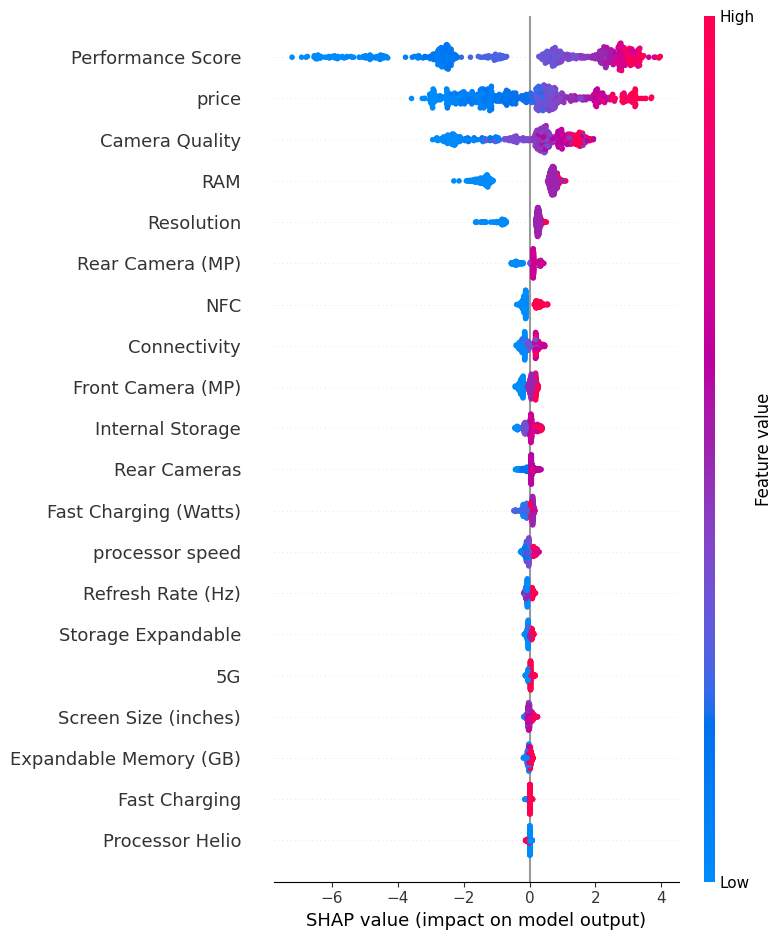

In [58]:
# Calculate SHAP values for the entire training set
shap_values = explainer.shap_values(X_train_trans) 

# Initialize JS visualization
shap.initjs()

# Summary plot 
shap.summary_plot(shap_values= shap_values, features = X_train_trans, feature_names = make_columns_readable(X_train_trans))